Exploration: what does a 3DFFT of seismic data produce? How does acquisition footprint manifest itself?

In [7]:
import numpy as np
import scipy as sp
from scipy import ndimage as ndi
from numpy.fft import fft2, ifft2, fftshift, ifftshift, fftn

from skimage import io
from skimage.util import img_as_float
from skimage.filters import gaussian
from skimage.color import rgb2gray, label2rgb
from skimage.feature import peak_local_max, canny
from skimage.restoration import denoise_tv_chambolle
from skimage.draw import  circle
import skimage.morphology as morph
from skimage.measure import label, compare_ssim
import skimage.exposure as skie
from astropy.convolution import convolve, Gaussian2DKernel
import matplotlib.pyplot as plt

from ipywidgets import interact, interactive, interact_manual, FloatSlider, IntSlider, fixed
import ipywidgets as widgets
from IPython.display import display
import matplotlib.patches as patches

Load example dataset I'm familiar with (F3):

In [4]:
#The data file used for algo development
devfile = "../images_and_data/F3_original_subvolume_IL230-430_XL475-675_T200-1800.npy"

#Load it
data = np.load(devfile)

print("Data shape:" + str(data.shape))

Data shape:(201, 201, 401)


Have a gander at the data:

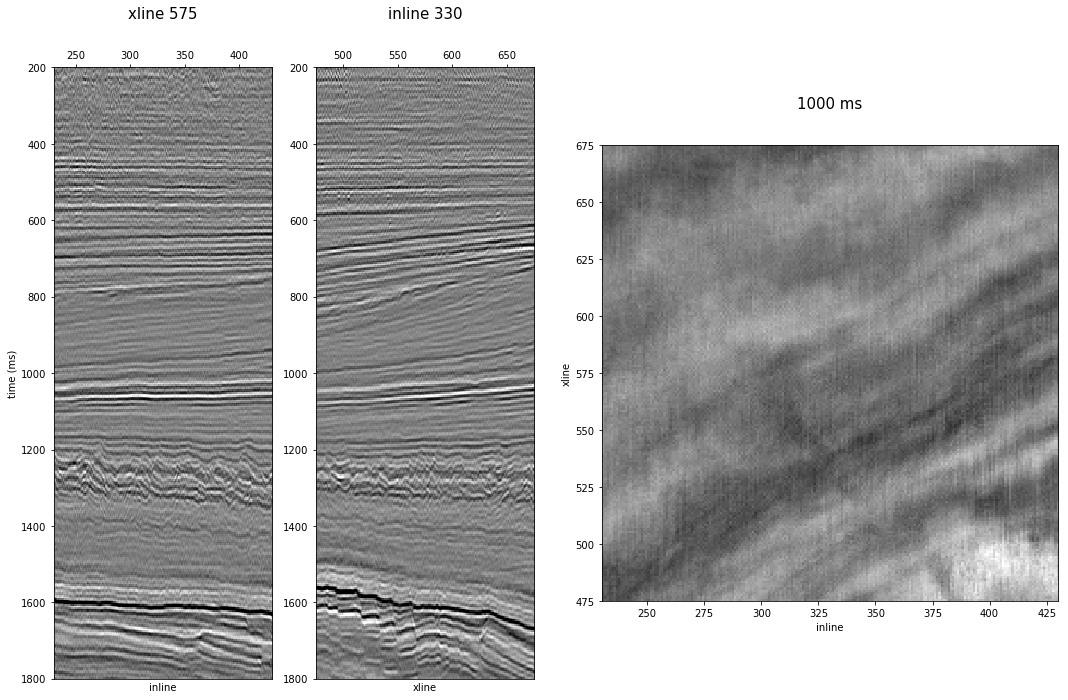

In [6]:
# find 99th percentile of amplitude for plot scaling
plotamp = np.percentile(data, 99.9)

# Plot the 3D data
atts = plt.figure(figsize=(18,12))

# Look at XL index 100
ax1 = atts.add_subplot(141)
ax1.imshow(data[:,100,:1000].T,extent=(230,430,1800,200), cmap="gray",vmin=-plotamp, vmax=plotamp, aspect='0.35')
ax1.xaxis.tick_top()
plt.text(0.5, 1.08, 'xline 575', fontsize=15,horizontalalignment='center',transform = ax1.transAxes)
ax1.set_xlabel('inline')
ax1.set_ylabel('time (ms)')
#ax1.axes.get_yaxis().set_ticks(times[::50])

# Look at IL index 100
ax1 = atts.add_subplot(142)
ax1.imshow(data[100,:,:1000].T,extent=(475,675,1800,200), cmap="gray",vmin=-plotamp, vmax=plotamp, aspect='0.35')
ax1.xaxis.tick_top()
plt.text(0.5, 1.08, 'inline 330', fontsize=15,horizontalalignment='center',transform = ax1.transAxes)
ax1.set_xlabel('xline')
#ax1.set_ylabel('time (ms)')
#ax1.axes.get_yaxis().set_ticks([])

# Look at T index 200
ax1 = atts.add_subplot(122)
ax1.imshow(data[:,:,200].T, extent=(230, 430, 475, 675), cmap="gray",vmin=-plotamp, vmax=plotamp, aspect='1') # I didn't plot the Transpose here
plt.text(0.5, 1.08, '1000 ms', fontsize=15,horizontalalignment='center',transform = ax1.transAxes)
ax1.set_xlabel('inline')
ax1.set_ylabel('xline');

Calculate the 3Dfft and confirm shape:

In [13]:
FS3D = fftn(data) # Frequency Spectrum 3D

# Create a real version for visualization
FS3D_real = np.log(np.abs(fftshift(FS3D)))

FS3D.shape

(201, 201, 401)

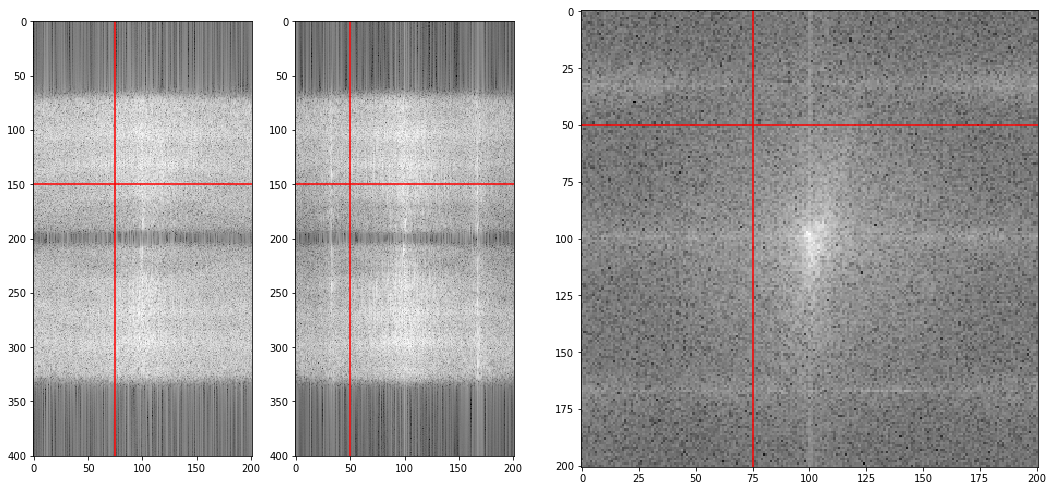

In [62]:
atts = plt.figure(figsize=(18,12))

XL, IL, T = 50, 75, 150

# Look at "XL" index 50
ax1 = atts.add_subplot(141)
ax1.imshow(FS3D_real[:,XL,:].T, cmap="gray")
ax1.axhline(T, color='red')
ax1.axvline(IL, color='red')

# Look at "IL" index 50
ax1 = atts.add_subplot(142)
ax1.imshow(FS3D_real[IL,:,:].T, cmap="gray")
ax1.axhline(T, color='red')
ax1.axvline(XL, color='red')

# Look at "T" index 150
ax1 = atts.add_subplot(122)
ax1.imshow(FS3D_real[:,:,T].T, cmap="gray")
ax1.axhline(XL, color='red')
ax1.axvline(IL, color='red');

Weird banding for slices 0-65, 195-205, and 340-400.
I think we're seeing the effects of the band-limited nature of the time data! Let's compare at just one 'trace' for samples 200-0 with the frequency spectrum for one of the traces:

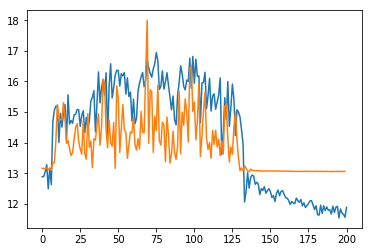

In [43]:
FS75 = np.abs(fftn(data[75,75,:]))

plt.plot(FS3D_real[75,75,200:])
plt.plot(5*FS75[:200]/np.max(FS75)+13) # I scaled and biased the spectrum

The matching bandwidths confirms that the Z axis of the 3DFFT corresponds to a spectrum of a seismic trace.


But what's with the banding (sort of grid pattern?) seen in the 3DFFT? Is it caused by the non-square input data? Test this by looking at the 3DFFT of a square version of this data.

In [46]:
# Instead of padding the data, try trimming data to make it square!

FS3Ds = fftn(data[:,:,:201]) # Frequency Spectrum 3D

# Create a real version for visualization
FS3Ds_real = np.log(np.abs(fftshift(FS3Ds)))

FS3Ds.shape

(201, 201, 201)

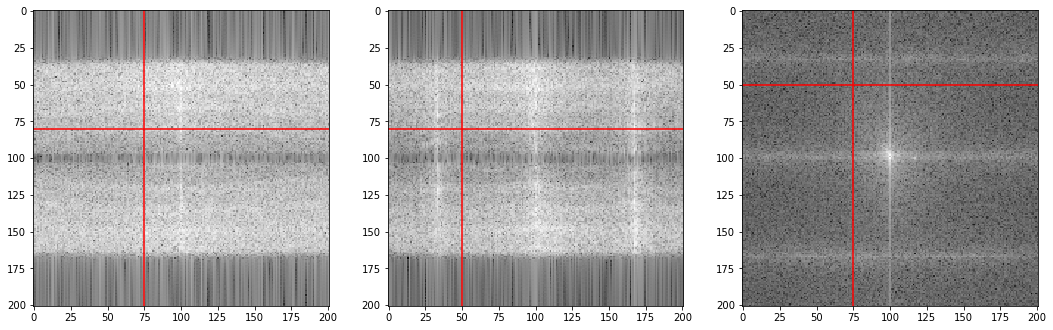

In [78]:
atts = plt.figure(figsize=(18,12))

XL, IL, T = 50, 75, 80

# Look at "XL" index 50
ax1 = atts.add_subplot(131)
ax1.imshow(FS3Ds_real[:,XL,:].T, cmap="gray")
ax1.axhline(T, color='red')
ax1.axvline(IL, color='red')

# Look at "IL" index 50
ax1 = atts.add_subplot(132)
ax1.imshow(FS3Ds_real[IL,:,:].T, cmap="gray")
ax1.axhline(T, color='red')
ax1.axvline(XL, color='red')

# Look at "T" index 150
ax1 = atts.add_subplot(133)
ax1.imshow(FS3Ds_real[:,:,T].T, cmap="gray")
ax1.axhline(XL, color='red')
ax1.axvline(IL, color='red');

Hmm... those grids are still visible.

Maybe the grid pattern is related to the footprint? Let's compare the grid to an example of footprint on a 2DFFT of a slice.

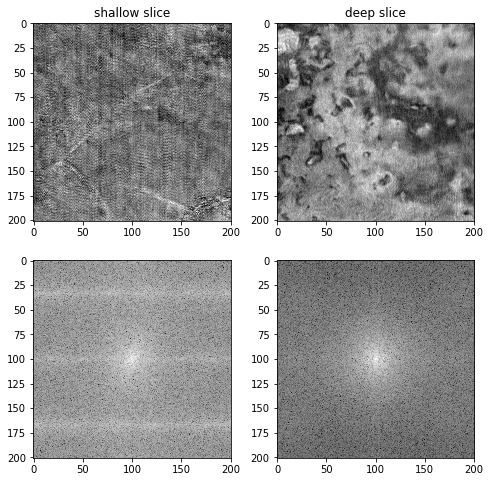

In [94]:
FSslice_shallow = fft2(data[:,:,25]) 
FSslice_deep = fft2(data[:,:,250])

# Create a real version for visualization
FSslice_shallow_real = np.log(np.abs(fftshift(FSslice_shallow)))
FSslice_deep_real = np.log(np.abs(fftshift(FSslice_deep)))

atts = plt.figure(figsize=(8,8))
ax1 = atts.add_subplot(221)
ax1.imshow(data[:,:,25].T, cmap='gray')
ax3 = atts.add_subplot(223)
ax3.imshow(FSslice_shallow_real.T, cmap='gray')
ax1.set_title('shallow slice')
ax2 = atts.add_subplot(222)
ax2.imshow(data[:,:,250].T, cmap='gray')
ax4 = atts.add_subplot(224)
ax4.imshow(FSslice_deep_real.T, cmap='gray')
ax2.set_title('deep slice');

Ah! The grid pattern seen _is_ the footprint. However, the footprint is seen most strongly for shallow time.